In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(1, '../')

import experiment
import pickle
from utils import *
from Architectures import *
import random, os
suppress_warnings()
EPOCHS = 256


def countp(model, params):
    tmp = model(**params)
    tmp.build(input_shape=(1,15,7))
    return tmp.count_params()


n_params = []

os.environ['PYTHONHASHSEED']=str(0)
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

def human_format(num):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    # add more suffixes if you need them
    return '%.0f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])


filename = '../data/data100k_raw_combined_atlas_cut.pkl'
n_experiments = 8
SUFFIX = 'latent28'


#TESTING ######
# EPOCHS = 2
# filename = '../data/data50k_raw_combined_atlas_cut_small.pkl'
# n_experiments = 2
# SUFFIX = 'latent28'
###########

ERROR in cling::CIFactory::createCI(): cannot extract standard library include paths!
Invoking:
  LC_ALL=C x86_64-conda-linux-gnu-c++  -O3 -DNDEBUG -xc++ -E -v /dev/null 2>&1 | sed -n -e '/^.include/,${' -e '/^ \/.*++/p' -e '}'
Results was:
With exit code 0


Welcome to JupyROOT 6.22/08


2022-10-09 11:35:35.818720: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-09 11:35:35.818840: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
import seaborn as sns
import os

#to get latex to work 
os.environ['PATH'] = "%s:/usr/local/cuda-11.2/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/anaconda/bin:/home/delon/texlive/bin/x86_64-linux:/home/delon/.local/bin:/home/delon/bin"%os.environ['PATH']
PI = experiment.Experimenter(filename)
PI.fromSaved(suffix=SUFFIX)

Initializing Experimenter
	Loading Data from ../data/data100k_raw_combined_atlas_cut.pkl
	Data Loaded
	Creating Splits
	Splits Created
Done initalizing
Loading Experimenter from Saved Experimenter at /data/delon/experimenter/data100k_raw_combined_atlas_cutlatent28
Experimenter Loaded
Getting split
Split Stored
Loading models
{'latent_two_5_(64, 128, 256, 128, 2)_64': 'models/data100k_raw_combined_atlas_cut_latent_two_5_(64, 128, 256, 128, 2)_64latent28', 'latent_eight_5_(64, 128, 256, 128, 8)_64': 'models/data100k_raw_combined_atlas_cut_latent_eight_5_(64, 128, 256, 128, 8)_64latent28'}
Loaded latent_two_5_(64, 128, 256, 128, 2)_64 from models/data100k_raw_combined_atlas_cut_latent_two_5_(64, 128, 256, 128, 2)_64latent28
Loaded latent_eight_5_(64, 128, 256, 128, 8)_64 from models/data100k_raw_combined_atlas_cut_latent_eight_5_(64, 128, 256, 128, 8)_64latent28


2022-10-09 11:36:15.711956: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-09 11:36:15.712210: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-09 11:36:15.712265: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (top1.hep.utexas.edu): /proc/driver/nvidia/version does not exist
2022-10-09 11:36:15.713464: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
latent2 = PI.models['latent_two_5_(64, 128, 256, 128, 2)_64']
latent8 = PI.models['latent_eight_5_(64, 128, 256, 128, 8)_64']

In [5]:
X_test_latent, y_test_latent = PI.get_test_dataset('latent_two')

In [6]:
X_test_ATLAS, y_test_ATLAS = gen_dataset_high_level(PI.events_test, PI.events_oup_test, PI.events_tag_test, 
                                                    mrel=True ,mtautau=True, colinear_approx=False, tmm=False, ca2=True)
X_test_ATLAS = np.array(X_test_ATLAS)



100%|██████████| 60000/60000 [00:48<00:00, 1240.09it/s]


In [7]:
#dropping nan
hasnan = np.array([np.isnan(event[-1]) for event in X_test_ATLAS])
print(sum(hasnan)/len(hasnan))

0.0


In [8]:
latent_label_28 = y_test_latent.numpy()

In [9]:
def get_latent(model, X_test):
    latent_getter = LatentGetter(model.layers[0:3], condensed=True)
    latent_reps = latent_getter.predict(X_test.numpy())
    return latent_reps

In [10]:
latent2_features = get_latent(latent2, X_test_latent)

2022-10-09 11:37:10.865342: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-09 11:37:10.868261: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2397305000 Hz


In [11]:
latent8_features = get_latent(latent8, X_test_latent)

In [12]:
X_test_ATLAS = X_test_ATLAS[~hasnan]

In [13]:
latent2_features = latent2_features[~hasnan]
latent8_features = latent8_features[~hasnan]

In [14]:
from scipy.stats import spearmanr

In [15]:
l2_corr = np.array([[np.abs(spearmanr(latent2_features.T[latent_idx], X_test_ATLAS.T[ATLAS_idx])[0])
                     for ATLAS_idx in range(len(X_test_ATLAS.T))]
                    for latent_idx in range(len(latent2_features.T))])
l8_corr = np.array([[np.abs(spearmanr(latent8_features.T[latent_idx], X_test_ATLAS.T[ATLAS_idx])[0])
                     for ATLAS_idx in range(len(X_test_ATLAS.T))]
                    for latent_idx in range(len(latent8_features.T))])

In [16]:
import seaborn as sns

In [17]:
plt.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True

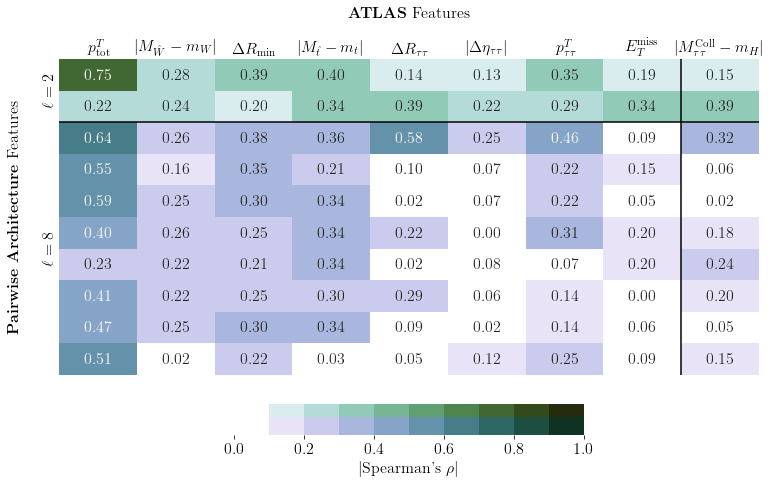

In [21]:
plt.rcParams['font.size'] = 16
cmapl2 = sns.cubehelix_palette(start=14/10, light=1, n_colors=10)
cmapl8 = sns.cubehelix_palette(start=20/10, light=1, n_colors=10)

cmap =sns.cubehelix_palette(start=26/10, light=.97, n_colors=10)
plt.figure(figsize=(11,7))
ax = sns.heatmap(np.concatenate([l2_corr, l8_corr]), annot=True, fmt=".2f",  linewidths=.5, cmap=cmap,  cbar=0,
                 vmin=0, vmax=1, cbar_kws={'label': r"$\big|$Spearman's $\rho\big|$", "orientation": "horizontal", 'pad':0.03, 'shrink':0.5})
ax.hlines([2], *ax.get_xlim(), colors=["black"])

ax.vlines([8], *ax.get_ylim(), colors=["black"])
ax.xaxis.tick_top()
ax.tick_params(axis=u'both', which=u'both',length=0)

l2_mask = np.array([[i>=2 for j in range(9)] for i in range(10)])
sns.heatmap(np.concatenate([l2_corr, l8_corr]), mask=l2_mask, cmap=cmapl2, cbar=True, ax=ax, vmin=0, vmax=1,
           cbar_kws={"orientation": "horizontal", 'pad':-0.1888, 'ticks':[], 'shrink':0.5})

l8_mask = np.array([[i<2 for j in range(9)] for i in range(10)])
sns.heatmap(np.concatenate([l2_corr, l8_corr]), mask=l8_mask, cmap=cmapl8, cbar=True, ax=ax, vmin=0, vmax=1,
           cbar_kws={'label': r"$|$Spearman's $\rho|$", "orientation": "horizontal", 'pad':0.1, 'shrink':0.5})


ax.tick_params(axis=u'x', which=u'both',labelrotation=0)
atlas_labels=[r'$p^T_{\rm tot}$',
              r'$|M_{\hat W}-m_W|$',
              r'$\Delta R_{\rm min}$',
              r'$|M_{\hat t}-m_t|$', 
              r'$\Delta R_{\tau\tau}$',
              r'$|\Delta \eta_{\tau\tau}|$',
              r'$p^T_{\tau\tau}$',
              r'$E_T^{\rm miss}$',
              r'$|M_{\tau\tau}^{\rm Coll}-m_H|$', 
             ]
ax.set_xticks(np.arange(9)+0.5, labels=atlas_labels)
plt.xlabel(r'\textbf{ATLAS} Features'+'\n')
ax.xaxis.set_label_position('top')

ax.set_yticks([1,6], labels=[ r'$\ell=2$',  r'$\ell=8$'])

plt.ylabel(r'\textbf{Pairwise Architecture} Features'+'\n')

plt.savefig('figures/spearman_correlations.pdf', bbox_inches='tight')

In [19]:
hasnan = [np.isnan(event[-1]) for event in X_test_ATLAS]

In [20]:
sum(hasnan)/len(hasnan)

0.0